In [1]:
import keras

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
#from keras.layers import CategoryEncoding
import keras_tuner as kt

import os,io

import tensorflow as tf

import chess
import chess.pgn
from chess.engine import PovScore, Mate, Cp

from io import StringIO

import random

import numpy as np

NUM_MOVES = 40 #number of moves to store in tensor

2025-01-01 16:18:56.558229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_ratings(game):

    return int(game.headers['WhiteElo']),int(game.headers['BlackElo'])

def rating_to_output(rating):
    ret = np.zeros(48)
    r = int((rating-600)/50)
    if r>47:
        r = 47
    if r<0:
        r = 0
    ret[r] = 1
    return ret

def make_game_tensor(game,num_moves):
  #print(game)
  gt1 = np.zeros((num_moves,136))
  gt2 = np.zeros((num_moves,136))
  #we will make two game tensors from a game, one for each player. 
  #The tensor will be a 136 element tensor. The first 64 elements will be the board state, the next 64 will be the board state after the move. Element 129
  # is the move number. Element 130 is the time on the clock at the start of the move and element 131 is the time on the clock after the move. Element 132 is the time on the clock of the opponent.
  #Element 133 is the evaluation of the position before the move and 134 is the evaluation of the position after the move. Element 135 is a 1 if the evaluation before the move is a mate in ... and 0 otherwise while element 136 is a 1 if the evaluation after the move is a mate in ... and 0 otherwise.

  #The board state itself is a 64 element tensor with 0 for empty spaces, 1...6 for the current color's pieces and 7...12 for the opponent's pieces. 
  board = game.board()
  m = None #current move
  white_time = 300
  black_time = 300

  move_number = 0

  current_eval = PovScore(Cp(0), chess.WHITE)
  current_move_color = chess.WHITE #start with white

  while True:
  
    t = np.zeros(136)

    for i in range(64):
        if board.piece_at(i)==None:
          t[i] = 0
        elif board.piece_at(i).color == current_move_color:
           t[i] = board.piece_at(i).piece_type
        else:
           t[i] = board.piece_at(i).piece_type+7
      
    #get the evaluation, time etc.

    t[128] = move_number//2 #move number

    t[129] = white_time if current_move_color == chess.WHITE else black_time
  
    t[131] = black_time if current_move_color == chess.WHITE else white_time
  
    if current_eval == None:
      t[135] = 1
      t[134] = 0
    elif current_eval.pov(current_move_color).is_mate():
      t[133] = 1
      t[132] = current_eval.pov(current_move_color).mate()
    else:
      t[133] = 0
      t[132] = current_eval.pov(current_move_color).score()
  
    if move_number == 0:
       m = game.next()
    else:
      m = m.next()
    if m == None:
      break

    if current_move_color == chess.WHITE:
      white_time = m.clock()
    else:
      black_time = m.clock()
      
    current_eval = m.eval()
    board = m.board()

    for i in range(64):
        if board.piece_at(i)==None:
          t[i+64] = 0
        elif board.piece_at(i).color == current_move_color:
          t[i+64] = board.piece_at(i).piece_type
        else:
          t[i+64] = board.piece_at(i).piece_type+7
  
    t[130] = white_time if current_move_color == chess.WHITE else black_time

    if current_eval == None:
      t[135] = 1
      t[134] = 0
    elif current_eval.pov(current_move_color).is_mate():
      t[135] = 1
      t[134] = current_eval.pov(current_move_color).mate()
    else:
      t[135] = 0
      t[134] = current_eval.pov(current_move_color).score()

    if current_move_color == chess.WHITE:
      gt1[move_number//2] = t
    else:
      gt2[move_number//2] = t

    current_move_color = not current_move_color

    move_number+=1

    if move_number == num_moves*2:
      break

  return np.array(gt1),np.array(gt2)


In [3]:
def check_game(string):
    #checks if there is a string 'TimeControl "600+0"' in the game string, whether the string contains the string 'eval' and whether the string 'WhiteRatingDiff "X"' and 'BlackRatingDiff "Y"' are present and the absolute values of X and Y are less than 40.

    #print("GAME STRING:",string,"END GAME STRING")
    if string == "":
        return None

    if 'TimeControl "300+0"' in string and 'eval' in string and 'WhiteRatingDiff' in string and 'BlackRatingDiff' in string:
        white_diff = int(string.split('WhiteRatingDiff "')[1].split('"')[0])
        black_diff = int(string.split('BlackRatingDiff "')[1].split('"')[0])
        if abs(white_diff) < 40 and abs(black_diff) < 40:
            return True
        
    return False

def extract_games(source_file,target_file): 
    tf = open(target_file,'w')
    
    game = ""

    with open(source_file) as f:
        for line in f.readline():
            if line.startswith("[Event ") and game=="":
                game=line
            elif line.startswith("[Event "):
                if check_game(game):
                    tf.write(game)
                game = line
            else:
                game+=line

def extract_games_stdin(target_file): 
    tf = open(target_file,'w')
    
    game = ""

    for line in sys.stdin:
        if line.startswith("[Event ") and game=="":
            game=line
        elif line.startswith("[Event "):
            if check_game(game):
                tf.write(game)
            game = line
        else:
            game+=line
    

In [4]:
def make_data(game_file,path,target_file): #assumes that the game file is a pgn file with games that have the correct time control, evals and rating differences, see check_game function
    found_count = 0
    X,y, = [], []

    with open(game_file) as f:
        while True:
            game = chess.pgn.read_game(f)
            if game == None:
                break
            if game.headers['Termination'] == "Abandoned" or game.headers['Termination'] == "Rules infraction" or len(list(game.mainline_moves())) < 15:
                continue
            y1,y2 = get_ratings(game)
            gt1,gt2 = make_game_tensor(game,num_moves=NUM_MOVES)
            X.append(gt1)
            X.append(gt2)
            y.append(y1)
            y.append(y2)
            found_count += 1
            if found_count % 1000 == 0:
                print("Found " + str(found_count) + " games")
                #np.savez_compressed(os.path.join(path,target_file + "_X.npz"),np.array(X))
                #np.savez_compressed(os.path.join(path,target_file + "_y.npz"),np.array(y))
                
    X = np.array(X)
    y = np.array(y)
    
    #save the data to the target file
    np.savez_compressed(os.path.join(path,target_file + "_X.npz"),X)
    np.savez_compressed(os.path.join(path,target_file + "_y.npz"),y)

def load_data(path,target_file):
    X = np.load(os.path.join(path,target_file + "_X.npz"))["arr_0"]
    y = np.load(os.path.join(path,target_file + "_y.npz"))["arr_0"]
    

    return X,y


#if the data doesn't exist, generate it
if not os.path.exists("data/all_data/data_X.npz"):
    make_data("data/all_data/extracted_games05.pgn","data/all_data/","data")

X,y = load_data("data/all_data","data")

#X = simplify_data_eval_only(X)
#X = simplify_data_no_eval(X)

In [10]:
def bindata(X,y):
    bins = {}
    for i in range(len(y)):
        bin = int(y[i]/50)
        if bin not in bins:
            bins[bin] = []
        
        bins[bin].append((X[i],y[i]))
        
    return bins

def oversample(bins,num_samples):
    #pick a total of num_samples samples from the bins by selecting a bin from bins at random and then selecting a sample from that bin at random
    retX,retY = [],[]
    for i in range(num_samples):
        bin = random.choice(list(bins.keys()))
        sample = random.choice(bins[bin])
        retX.append(sample[0])
        retY.append(sample[1])

    return np.array(retX),np.array(retY)
    

In [15]:
def model_builder(hp):

    #inputs = Input(shape=(NUM_MOVES, 132)) #if no eval is used
    inputs = Input(shape=(NUM_MOVES, 136)) #full tensor
    #inputs = Input(shape=(NUM_MOVES,8)) #if only the eval is used
    
    x = inputs

    #prepare hyperparameter tuning

    num_LSTM_layers = hp.Int('num_LSTM_layers',0,2)
    num_LSTM_units=[]
    for i in range(num_LSTM_layers+1):
        num_LSTM_units.append(hp.Int('lstm'+str(i)+'_units',
                                     min_value = 32,
                                     max_value = 64,
                                     step=16))
        
                                     
    num_dense_layers = hp.Int('num_dense_layers',1,3)
    num_dense_units = []
    dense_activation = []

    for i in range(num_dense_layers):
        num_dense_units.append(hp.Int('dense'+str(i)+'_units',
                                     min_value = 32,
                                     max_value = 128,
                                     step=16))
        dense_activation.append(hp.Choice("dense"+str(i)+"_activation",["relu", "leaky_relu","tanh"]))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-2])

    #make the NN

    for i in range(num_LSTM_layers):
        x = LSTM(num_LSTM_units[i],return_sequences = True)(x)

    #add a final LSTM layer that doesn't return sequences
    x = LSTM(num_LSTM_units[-1])(x)
    
    for i in range(num_dense_layers):
        x = Dense(num_dense_units[i],activation = dense_activation[i])(x)


    output = Dense(1,activation='relu',name="Elo")(x)
    

    #Alternative: set outputs to be hot encoded between 48 values
    #output1 = Dense(48,activation='softmax',name="WhiteElo")(x)
    #output2 = Dense(48,activation='softmax',name="BlackElo")(x)

    model = keras.Model(inputs=inputs,outputs=[output])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss={'Elo':'mae'},
                    metrics={'Elo':'mae'})

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('modelCP.keras', save_best_only=True,mode='auto',monitor='val_loss')

#tuner.search(X,y,epochs=100,validation_split=0.2,callbacks=[stop_early])
tuner.search(OX,Oy,epochs=100,validation_data=(X_val,y_val),callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps.values)

model = tuner.hypermodel.build(best_hps)

#history = model.fit(X,y,epochs=100,validation_split=0.2,callbacks=[stop_early,save])
model.save('modelHB.keras')

Trial 2 Complete [00h 09m 30s]
val_loss: 248.96511840820312

Best val_loss So Far: 248.96511840820312
Total elapsed time: 00h 18m 05s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1                 |2                 |num_LSTM_layers
32                |48                |lstm0_units
1                 |1                 |num_dense_layers
112               |32                |dense0_units
leaky_relu        |leaky_relu        |dense0_activation
0.001             |0.01              |learning_rate
64                |32                |lstm1_units
80                |32                |dense1_units
leaky_relu        |relu              |dense1_activation
48                |32                |lstm2_units
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/

In [11]:
#select 20% of the data to be used for validation

split = int(0.8*len(X))

X_train = X[:split]
y_train = y[:split]

X_val = X[split:]
y_val = y[split:]

bins = bindata(X_train,y_train)
print("bins made")
OX,Oy = oversample(bins,len(X))



bins made


In [12]:
inputs = Input(shape=(NUM_MOVES, 136)) #full tensor
x = LSTM(40,return_sequences = True)(inputs)
x = LSTM(32)(x)
x = Dense(80,activation='relu')(x)

output1 = Dense(1,activation='relu',name="Elo")(x)


model = keras.Model(inputs=inputs,outputs=[output1])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss={'Elo':'mae'},
                    metrics={'Elo':'mae'})

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('modelO1.keras', save_best_only=True,mode='auto',monitor='val_loss')

model.fit(OX,Oy,epochs=100,shuffle=True,validation_data=(X_val,y_val),callbacks=[stop_early,save])

#model.fit(X,y,epochs=100,shuffle=True,validation_split=0.2,callbacks=[stop_early,save])

#modelB.save('modelO1B.keras')

Epoch 1/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 228s 31ms/step - loss: 649.3950 - mae: 649.3950 - val_loss: 284.8401 - val_mae: 284.8401
Epoch 2/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 198s 28ms/step - loss: 213.3430 - mae: 213.3430 - val_loss: 246.7147 - val_mae: 246.7147
Epoch 3/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 197s 28ms/step - loss: 200.5090 - mae: 200.5090 - val_loss: 232.7653 - val_mae: 232.7653
Epoch 4/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 204s 29ms/step - loss: 193.0782 - mae: 193.0782 - val_loss: 226.0233 - val_mae: 226.0233
Epoch 5/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 205s 29ms/step - loss: 186.9468 - mae: 186.9468 - val_loss: 216.0979 - val_mae: 216.0979
Epoch 6/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 224s 31ms/step - loss: 183.4679 - mae: 183.4679 - val_loss: 241.0153 - val_mae: 241.0153
Epoch 7/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 225s 32ms/step - loss: 179.6632 - mae: 179.6632 - val_loss: 216.8736 - val_mae: 216.8736
Epoch 8/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 204s 29ms/step - loss: 176.1404 -

In [13]:
from keras.layers import TimeDistributed

inputs = Input(shape=(NUM_MOVES, 136)) #full tensor

#make a dense layer for each of the NUM_MOVES elements. The output of each dense layer is a 1D tensor of 137 elements. Each of these tensors is then concatenated to form a 2D tensor of 137xNUM_MOVES elements. This tensor is then fed into an LSTM layer.

x = TimeDistributed(Dense(80,activation = 'relu'))(inputs)

x = LSTM(40,return_sequences = True)(x)
x = LSTM(32)(x)
x = Dense(60,activation='relu')(x)

output = Dense(1,activation='relu',name="Elo")(x)

model = keras.Model(inputs=inputs,outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss={'Elo':'mae'},
                    metrics={'Elo':'mae'})


#select 20% of the data to be used for validation


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('modelOT.keras', save_best_only=True,mode='auto',monitor='val_loss')

#model.fit(X,y,epochs=100,validation_split=0.2,shuffle=True,callbacks=[stop_early,save])
model.fit(OX,Oy,
          epochs=100,
          shuffle=True,
          validation_data=(X_val,y_val),
          callbacks=[stop_early,save])

Epoch 1/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 284s 39ms/step - loss: 782.0889 - mae: 782.0889 - val_loss: 248.1543 - val_mae: 248.1543
Epoch 2/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 252s 35ms/step - loss: 235.4637 - mae: 235.4637 - val_loss: 269.3246 - val_mae: 269.3246
Epoch 3/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 224s 31ms/step - loss: 211.0840 - mae: 211.0840 - val_loss: 250.6162 - val_mae: 250.6162
Epoch 4/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 221s 31ms/step - loss: 201.2691 - mae: 201.2691 - val_loss: 224.1663 - val_mae: 224.1663
Epoch 5/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 220s 31ms/step - loss: 194.2975 - mae: 194.2975 - val_loss: 218.3687 - val_mae: 218.3687
Epoch 6/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 219s 31ms/step - loss: 188.6383 - mae: 188.6383 - val_loss: 220.7258 - val_mae: 220.7258
Epoch 7/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 225s 32ms/step - loss: 184.2579 - mae: 184.2579 - val_loss: 224.6676 - val_mae: 224.6676
Epoch 8/100
7130/7130 ━━━━━━━━━━━━━━━━━━━━ 227s 32ms/step - loss: 180.9700 -

In [14]:
def analyse_game(file,model):
    with open(file) as f:
        game = chess.pgn.read_game(f)
        gt1,gt2 = make_game_tensor(game,num_moves=NUM_MOVES)

        #gt = simplify_data_no_eval(gt)
        #gt = simplify_data_eval_only(gt)
        return model(np.array([gt1]),training=False),model(np.array([gt2]),training=False)
    
model = keras.models.load_model('modelO1.keras')

print(analyse_game("data/all_data/2200.pgn",model))
print(analyse_game("data/all_data/2000.pgn",model))
print(analyse_game("data/all_data/tubby.pgn",model))
print(analyse_game("data/all_data/jhudsy.pgn",model))

model = keras.models.load_model('modelOT.keras')

print()

print(analyse_game("data/all_data/2200.pgn",model))
print(analyse_game("data/all_data/2000.pgn",model))
print(analyse_game("data/all_data/tubby.pgn",model))
print(analyse_game("data/all_data/jhudsy.pgn",model))


(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2116.1333]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1907.5028]], dtype=float32)>)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1909.2122]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2112.9473]], dtype=float32)>)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2115.5286]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1976.9615]], dtype=float32)>)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1453.7723]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1527.852]], dtype=float32)>)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2030.9899]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1980.6711]], dtype=float32)>)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2083.7266]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2091

                   0
count  228946.000000
mean     1724.446162
std       561.820214
min       772.000000
25%      1236.000000
50%      1725.500000
75%      2211.000000
max      2686.000000
                   0
count  228946.000000
mean     1591.505840
std       292.022961
min       772.000000
25%      1385.000000
50%      1598.000000
75%      1799.000000
max      2686.000000


(array([6818., 4827., 4366., 4475., 4667., 4541., 4323., 4648., 4612.,
        4483., 4643., 4297., 4479., 4520., 4532., 4417., 4452., 4541.,
        4381., 4427., 4441., 4629., 4401., 4413., 4475., 4647., 4534.,
        4482., 4600., 4528., 4521., 4429., 4596., 4495., 4451., 4354.,
        4640., 4516., 4806., 4135., 4591., 4852., 4684., 4660., 3785.,
        3524., 5643., 2940., 5960., 5765.]),
 array([ 772.  ,  810.28,  848.56,  886.84,  925.12,  963.4 , 1001.68,
        1039.96, 1078.24, 1116.52, 1154.8 , 1193.08, 1231.36, 1269.64,
        1307.92, 1346.2 , 1384.48, 1422.76, 1461.04, 1499.32, 1537.6 ,
        1575.88, 1614.16, 1652.44, 1690.72, 1729.  , 1767.28, 1805.56,
        1843.84, 1882.12, 1920.4 , 1958.68, 1996.96, 2035.24, 2073.52,
        2111.8 , 2150.08, 2188.36, 2226.64, 2264.92, 2303.2 , 2341.48,
        2379.76, 2418.04, 2456.32, 2494.6 , 2532.88, 2571.16, 2609.44,
        2647.72, 2686.  ]),
 <BarContainer object of 50 artists>)

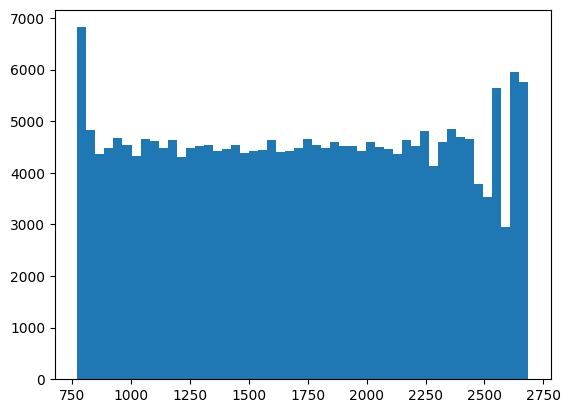

In [16]:
import pandas as pd

df = pd.DataFrame(Oy)
print(df.describe())

df = pd.DataFrame(y)
print(df.describe())

#plot the distribution of the ratings
import matplotlib.pyplot as plt

plt.hist(Oy,bins=50)

In [85]:
len(tf.keras.utils.to_categorical(y1,num_classes=48))

IndexError: index 1950 is out of bounds for axis 1 with size 48

In [30]:
np.set_printoptions(threshold=10_000)
for i in range(40):
    print(X[1][i]-X[17][i])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. 13.  0. 13.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. 

In [22]:
print(X[1][30])

[ 11.   9.  10.  12.  13.  10.   9.  11.   8.   8.   8.   8.   8.   8.
   8.   8.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   1.   1.   1.   1.
   4.   2.   3.   5.   6.   3.   2.   4.  11.   9.  10.  12.  13.  10.
   9.  11.   8.   8.   8.   8.   8.   8.   8.   8.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   1.   1.   1.   1.   1.   1.   4.   2.   3.   5.   6.   3.
   2.   4.  30. 300. 300. 300.  -3.   0.  -3.   0.]
